In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from scipy import linalg
from scipy import sparse
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit_aer.primitives import Sampler, Estimator
from qiskit.quantum_info import SparsePauliOp
from tqdm.auto import tqdm

from lib import (LinearCombinationHamiltonianSimulation, 
                HeatEquationEvolution, 
                LaplacianOperator2d,
                OperatorList, 
                DifferentialOperator, 
                ShiftOperator,
                IdentityOperator)

In [2]:
# Property for figures
plt.rcParams['font.family'] = "Liberation Serif" # UbuntuでのTimes New Romanの代用
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['font.size'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 3.0

In [3]:
backend = StatevectorSimulator()

# Parameters
T = 10.0
dt = 0.1
nx = 4
ny = 4
kappa = 0.1

# Classical setting
dt_cl = 0.001
op = LaplacianOperator2d(num_qubits_x=nx, num_qubits_y=ny)
n = op.num_qubits
K = op.to_matrix(sparse=False) * kappa

# Classical time evolution (FDM)
u = np.zeros((2**nx, 2**ny))
u[2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
u = u.flatten()
sc = 1 / np.linalg.norm(u)
u = u / np.linalg.norm(u)
u_list = [u]
for D in tqdm(range(int(T/dt_cl))):
    u = u + dt_cl * np.dot(K, u)
    u_list.append(u)
u_list = np.array(u_list)

# Quantum setting
op = HeatEquationEvolution(nx, dim=2, kappa=kappa)
H = op.to_matrix(sparse=False)
U = linalg.expm(-1j*H*dt)

# Quantum time evolution (LCHS)
psi_c = np.zeros((2**nx, 2**ny))
psi_c[2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
psi_c = psi_c.flatten()
psi_c = psi_c / np.linalg.norm(psi_c)

sim = LinearCombinationHamiltonianSimulation(op, num_qubits_lcu=8, lsb_pos=-1)
circ = sim.get_evolve_circ(dt, barrier=False, measure=False)
circ = transpile(circ, backend=backend, optimization_level=2, seed_transpiler=42)
n = sim._num_qubits
qc = QuantumCircuit(n)

qc.h(qc.qubits[ny + nx - 1]) # most significant bit for y
qc.h(qc.qubits[nx])
for i in range(1, ny-1):
    qc.cx(qc.qubits[ny + nx - 1], qc.qubits[nx + i])
qc.x(qc.qubits[ny + nx - 1])

qc.h(qc.qubits[0]) # least significant bit for x
for i in range(1, nx-1):
    qc.x(qc.qubits[i])

# save statevector
psi_c_list = [psi_c]
psi_q_list = []
qc.save_statevector(label="D0")
for D in tqdm(range(int(T/dt))):
    psi_c = np.dot(U, psi_c)
    psi_c_list.append(psi_c)

    qc = qc.compose(circ, inplace=False)
    qc.save_statevector(label="D{}".format(D+1))
print(qc.depth(), qc.num_qubits)
result = backend.run(qc).result().data(0)

for D in tqdm(range(int(T/dt)+1)):
    vec = result["D{}".format(D)].data[:2**sim._num_qubits_system]
    vec = np.exp(-1j*np.angle(vec[np.argmax(np.abs(vec))])) * vec # global phase
    psi_q_list.append(vec)
    
psi_c_list = np.array(psi_c_list)
psi_q_list = np.array(psi_q_list)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

49404 16


  0%|          | 0/101 [00:00<?, ?it/s]

0.1271438216815068 0.1541254979560376 0.15411982735898058
0.1928891800708543 0.22186768242215069 0.22186139936914945
0.35355339059327384 0.35355339059327373 0.35355339059327373


<Figure size 640x480 with 0 Axes>

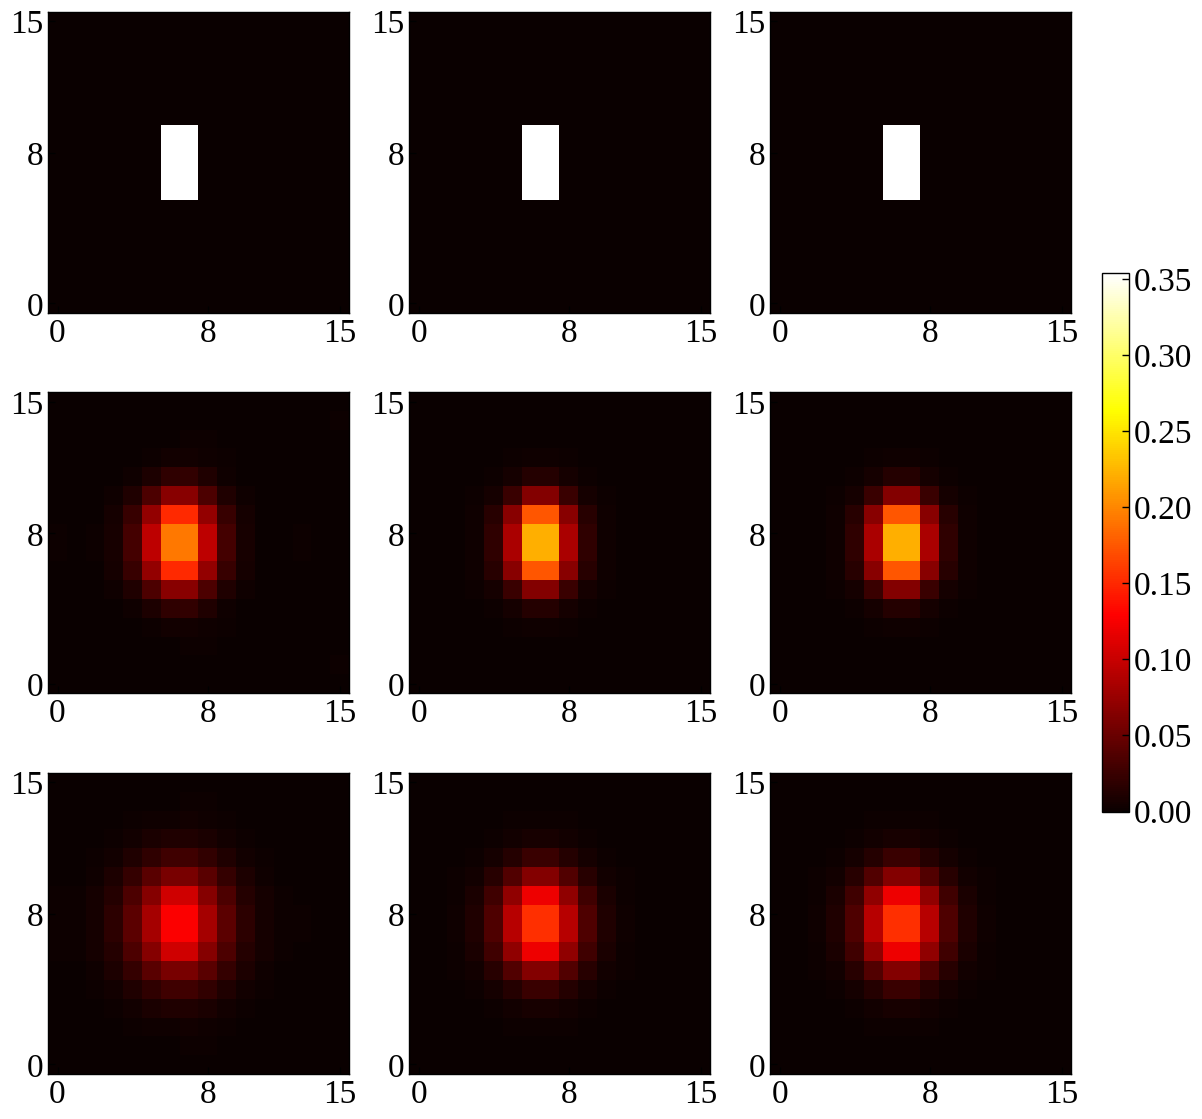

In [4]:
# Results
idx = [0, 5, 10]

u_list_tmp = u_list.copy()
psi_c_list_tmp = psi_c_list.copy()
psi_q_list_tmp = psi_q_list.copy()

vmax = None
vmin = None
for i in range(len(idx)):
    qmax = psi_q_list_tmp[int(idx[i]/dt), :].real.max()
    cmax = psi_c_list_tmp[int(idx[i]/dt), :].real.max()
    umax = u_list_tmp[int(idx[i]/dt_cl), :].real.max()
    
    qmin = psi_q_list_tmp[int(idx[i]/dt), :].real.min()
    cmin = psi_c_list_tmp[int(idx[i]/dt), :].real.min()
    umin = u_list_tmp[int(idx[i]/dt_cl), :].real.min()
    
    vmax_tmp = max(qmax, cmax, umax)
    vmin_tmp = min(qmin, cmin, umin)
    if vmax is None or vmax < vmax_tmp:
        vmax = vmax_tmp
    if vmin is None or vmin > vmin_tmp:
        vmin = vmin_tmp

cmap = 'hot'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig, ax = plt.subplots(len(idx), 3, figsize=(16, 14))
for i in reversed(range(len(idx))):
    x, y = np.meshgrid(np.arange(2**nx), np.arange(2**ny))
    z0 = psi_q_list_tmp[int(idx[i]/dt), :].real.reshape((2**ny, 2**nx))
    ax[i, 0].imshow(z0, norm=norm, cmap=cmap, origin='lower')
    ax[i, 0].set_aspect('equal')
    ax[i, 0].set_xticks(list(range(0, 2**nx, 8)) + [2**nx - 1])
    ax[i, 0].set_yticks(list(range(0, 2**ny, 8)) + [2**ny - 1])
    
    z1 = psi_c_list_tmp[int(idx[i]/dt), :].real.reshape((2**ny, 2**nx))
    ax[i, 1].imshow(z1, norm=norm, cmap=cmap, origin='lower')
    ax[i, 1].set_aspect('equal')
    ax[i, 1].set_xticks(list(range(0, 2**nx, 8)) + [2**nx - 1])
    ax[i, 1].set_yticks(list(range(0, 2**ny, 8)) + [2**ny - 1])

    z2 = u_list_tmp[int(idx[i]/dt_cl), :].real.reshape((2**ny, 2**nx))
    ax[i, 2].imshow(z2, norm=norm, cmap=cmap, origin='lower')
    ax[i, 2].set_aspect('equal')
    ax[i, 2].set_xticks(list(range(0, 2**nx, 8)) + [2**nx - 1])
    ax[i, 2].set_yticks(list(range(0, 2**ny, 8)) + [2**ny - 1])
    print(z0.max(), z1.max(), z2.max())
pp = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=ax.ravel().tolist(), pad=0.025, shrink=0.5)